In [ ]:
# P100
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-0f63c937-7f64-5e21-a3a0-8cc04ebb81f5)


# Data

연도별 이미지 개수  
90년대 이미지는 개수가 적으므로 1992 ~ 1999  
합쳐서 진행

1992 :	71  
1993 :	73  
1994 :	45  
1995 :	36  
1996 :	206  
1997 :	295  
1998 :	181  
1999 :	478  
2000 :	2154  
2001 :	2139  
2002 :	2170  
2003 :	1761  
2004 :	1802  
2005 :	2492  
2006 :	2913  
2007 :	3046  
2008 :	3407  
2009 :	3098  
2010 :	3479  
2011 :	3976  
2012 :	4184  
2013 :	4224  
2014 :	4264  
2015 :	4567  
2016 :	4976  
2017 :	4616  
2018 :	4532  
2019 :	5574  
2020 :	5492  
2021 :	3660  
2022 :	4327  
2023 :	944  

# Set up

In [ ]:
data_path = '/content/dataset'

## 이미지 파일 정리

In [ ]:
# !rm -rf "/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/rsc/dataset"
# %cd "/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/rsc"
# !unzip -q dataset.zip

/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/rsc


In [ ]:
# 그냥 label를 제공하는 것으로 전환

# ImageFolder 적용하기 위해서
# 폴더 나누기

# %cd "/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/rsc/year"
# for i in range(1999, 2023+1):
#   !mkdir {i}

/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/rsc/year


In [ ]:
# 데이터셋 총 이미지 개수
# 85182

In [ ]:
%cd /content
!unzip "/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/rsc/dataset.zip" | awk 'BEGIN {ORS=" "} {if(NR%2000==0)print "."}'

/content
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
import os
len(os.listdir('/content/dataset'))

85182

# Pytorch

## Dataset

In [ ]:
import os
import shutil
import glob
import math
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as T
from torchsummary import summary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# out_features 클래스가 총 25개
# 1999 ~ 2023
out = 6
model.classifier[-1] = nn.Linear(4096, out)
model = model.to(device)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)

In [ ]:
# img resize (224, 224)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
class Custom(Dataset):
    def __init__(self, ds_path, transform=None):
      self.imgs_path = glob.glob(os.path.join(ds_path, '*'))
      self.imgs_path.sort()
      self.transform = transform

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      path = self.imgs_path[idx]
      img = Image.open(path)   
      if self.transform:
          img = self.transform(img)

      year = int(path.split('_')[2])
      if year <= 1999:
        year = 0
      elif year <= 2004:
        year = 1
      elif year <= 2010:
        year = 2
      elif year <= 2014:
        year = 3
      elif year <= 2019:
        year = 4
      else:
        year = 5
      return img, year

In [ ]:
ds = Custom(data_path, transform)
ds[0][0].size()

torch.Size([3, 224, 224])

## train validation split

In [ ]:
import numpy as np

ds_size = len(ds)
idx = np.random.RandomState(2022).randint(ds_size, size=ds_size)
train_size = int(ds_size*0.7)
train_idx = idx[:train_size]
val_idx = idx[train_size:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
batch_size = 12
trainloader = DataLoader(ds, batch_size, sampler=train_sampler, num_workers=2)
valloader = DataLoader(ds, batch_size, sampler=val_sampler, num_workers=2)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
import math

def train(dataloader, model, loss_fn, optimizer):
  size = train_size
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    gap = math.ceil(size//batch_size / 5 )
    if batch % gap == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss : {loss:>7f} [{current/size*100:>0.2f}%]; current: {current}')

In [ ]:
def test(dataloader, model, loss_fn):
  size = ds_size - train_size
  num_batches = math.ceil(size / batch_size)

  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss, correct

In [19]:
epochs = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/output'

best_model = None
min_loss, max_acc = np.Inf, 0.

for t in range(epochs):
  print(f'epoch : {t+1} \n-------------------')
  train(trainloader, model, loss_fn, optimizer)
  val_loss, val_acc = test(valloader, model, loss_fn)
  if min_loss > val_loss:
    torch.save(model.state_dict(), os.path.join(save_path, "model_weights.pth"))
  if max_acc < val_acc:
    torch.save(model.state_dict(), os.path.join(save_path, "model_weights_acc.pth"))

print('Done')

epoch : 1 
-------------------
loss : 1.939292 [0.00%]; current: 0
loss : 0.507728 [20.00%]; current: 11928
loss : 0.543989 [40.01%]; current: 23856
loss : 0.981419 [60.01%]; current: 35784
loss : 0.138238 [80.02%]; current: 47712
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.144433 

epoch : 2 
-------------------
loss : 0.124044 [0.00%]; current: 0
loss : 0.101023 [20.00%]; current: 11928
loss : 0.176592 [40.01%]; current: 23856
loss : 0.019318 [60.01%]; current: 35784
loss : 0.088952 [80.02%]; current: 47712
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.068707 

epoch : 3 
-------------------
loss : 0.003607 [0.00%]; current: 0
loss : 0.103863 [20.00%]; current: 11928
loss : 0.000562 [40.01%]; current: 23856
loss : 0.085442 [60.01%]; current: 35784
loss : 0.256371 [80.02%]; current: 47712
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.063747 

epoch : 4 
-------------------
loss : 0.003757 [0.00%]; current: 0
loss : 0.081379 [20.00%]; current: 11928
loss : 0.010537 [40.01%]; current: 23856
lo

KeyboardInterrupt: ignored

# Model load

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn')
model.classifier[-1] = torch.nn.Linear(4096, 25)
model = model.to(device)

save_path = '/content/drive/MyDrive/Colab Notebooks/AiffelThon/project/model_weights.pth'
model.load_state_dict(torch.load(save_path))
model.eval()
print()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


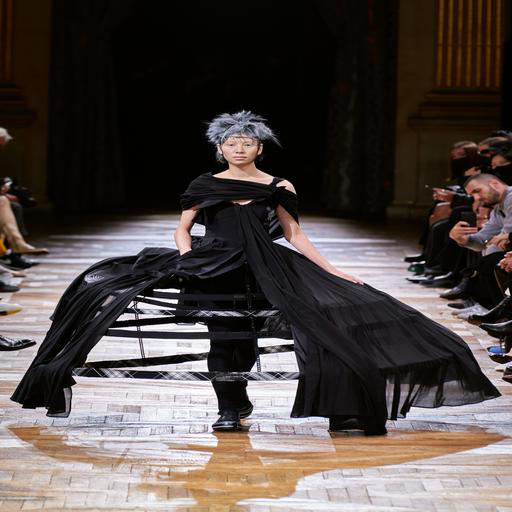

In [ ]:
Image.open(os.path.join(data_path, 'YohjiYamamoto_Spring-Ready-to-Wear_2022_03265.jpeg'))

In [ ]:
sample = iter(valloader)
next(sample)[0].size()

torch.Size([12, 3, 224, 224])

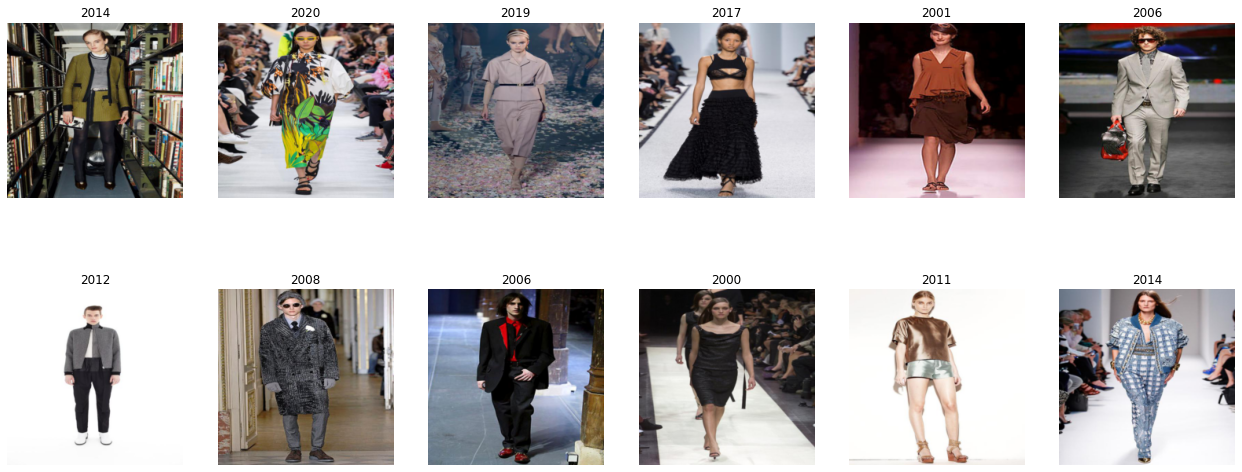

In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(2, 6, figsize=(22, 9))
ax = ax.flatten()

for X, y in valloader:
  sample = X.to(device)
  for idx, (img, label) in enumerate(zip(X, y)):
    arr = img*0.5 + 0.5
    arr *= 255
    arr = arr.cpu().numpy().astype(np.uint8)
    arr = np.transpose(np.squeeze(arr), (1, 2, 0))

    img = Image.fromarray(arr)
    ax[idx].set_title(str(int(label.cpu().numpy()) + 1999))
    ax[idx].imshow(img)
    ax[idx].axis(False)
  break
plt.show()

In [ ]:
model.eval()

result = model(sample)
result.argmax(1) + 1999

tensor([2014, 2020, 2019, 2017, 2001, 2006, 2012, 2008, 2006, 2000, 2011, 2014],
       device='cuda:0')

# 다른 데이터셋으로 테스트

In [ ]:
class CustomTest(Dataset):
    def __init__(self, ds_path, transform=None):
      self.imgs_path = sorted(glob.iglob(os.path.join(ds_path, '**/*.jpg'), recursive=True))
      self.transform = transform

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      path = self.imgs_path[idx]
      img = Image.open(path)   
      if self.transform:
          img = self.transform(img)

      year = int(path.split('/')[-2])
      if year <= 1999:
        year = 1999
      year -= 1999
      return img, year

In [ ]:
test_path = '/content/drive/MyDrive/Colab Notebooks/AiffelThon/year'

test_ds = CustomTest(test_path, transform)
len(test_ds)

803

In [ ]:
def get_img_fromtensor(ele_of_ds):
  tensor, label = ele_of_ds
  t = tensor * 0.5 + 0.5
  t *= 255
  t = t.cpu().numpy().astype(np.uint8)
  t = np.transpose(np.squeeze(t), (1, 2, 0))
  return Image.fromarray(t), int(label)+1999

2000


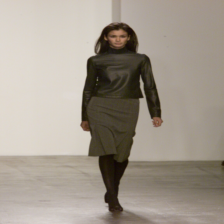

In [ ]:
# Sample
img, label = get_img_fromtensor(test_ds[0])
print(label)
img

In [ ]:
batch_size = 12
testloader = DataLoader(test_ds, batch_size, shuffle=True, num_workers=2)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = math.ceil(size / batch_size)

  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
test(testloader, model, loss_fn)

Test Error: 
 Accuracy: 24.5%, Avg loss: 4.613542 

